In [1]:
import keras
import numpy as np
import sklearn
from keras import backend as K
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import pickle
import datetime
import dill
from collections import defaultdict
from progressbar import progressbar
import matplotlib as mpl
from scipy import stats
from keras.optimizers import Adam

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
%matplotlib inline  
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [25,5]

Using TensorFlow backend.


In [2]:
# input image (30x200) as png file
# blur_dir = 'drive/My Drive/computer_vision/input_images/datav2/blur_img/train'
# original_dir = 'drive/My Drive/computer_vision/input_images/datav2/original_img/train'
# blur_train = 'data/train/blur'
# original_train = 'data/train/original'
# blur_dev = 'data/dev/blur'
# original_dev = 'data/dev/original'

train_blur_dirs = [('datav7/train30000/median','median'),
                   ('datav7/train30000/gaussian','gaussian'),
                   ('datav7/train30000/down','down')]
train_ori_dir = 'datav7/train30000/ori'

dev_blur_dirs = [('datav7/dev20000/median','median'),
                 ('datav7/dev20000/gaussian','gaussian'),
                 ('datav7/dev20000/down','down')]
dev_ori_dir = 'datav7/dev20000/ori'


test_blur_dirs = [('datav7/test20000/median','median'),
                 ('datav7/test20000/gaussian','gaussian'),
                 ('datav7/test20000/down','down')]
test_ori_dir = 'datav7/test20000/ori'

In [3]:
X_train = []
y_train = []
train_size = 30000 # for images in each folder

for (train_blur_dir,prefix) in train_blur_dirs:
    for i in range(train_size):
        X_train.append(os.path.join(train_blur_dir, '{}{}.png'.format(prefix,i)))
        y_train.append(os.path.join(train_ori_dir, '{}{}.png'.format('ori',i)))
        
X_dev = []
y_dev = []
dev_size = 20000 # for images in each folder

for (dev_blur_dir,prefix) in dev_blur_dirs:
    for i in range(dev_size):
        X_dev.append(os.path.join(dev_blur_dir, '{}{}.png'.format(prefix,i)))
        y_dev.append(os.path.join(dev_ori_dir, '{}{}.png'.format('ori',i)))
        
        
X_test = []
y_test = []
test_size = 20000 # for images in each folder

for (test_blur_dir,prefix) in test_blur_dirs:
    for i in range(test_size):
        X_test.append(os.path.join(test_blur_dir, '{}{}.png'.format(prefix,i)))
        y_test.append(os.path.join(test_ori_dir, '{}{}.png'.format('ori',i)))

In [11]:
from skimage.io import imread
from skimage import color
from keras.utils import Sequence

class generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=128):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         y = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_y])
#         return X.reshape(-1,50,300,1), y.reshape(-1,50,300,1)
    
    
class pred_generator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set          
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array([imread(file_name) for file_name in batch_x])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         return X.reshape(-1,50,300,1)

In [5]:
def psnr(y_true, y_pred):    
    return tf.image.psnr(y_true, y_pred, max_val=1)
  
    
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))*255.

# model

In [4]:
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, Flatten, Dense, Reshape, Add
from keras.models import Model

def get_model(input_shape): 
  #input 1-image (inverse)
    x = Input(shape = input_shape)
    c1 = Conv2D(64, 9, strides=1, activation = 'relu', padding='same')(x)
    c2 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(c1)
    c3 = Conv2D(input_shape[2], 5, strides=1, activation = 'relu', padding='same')(c2)
    model = Model(inputs = x, outputs = c3)
    return model


def get_model2(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 9, strides=1, padding='same')(x)
    b1 = BatchNormalization()(c1)
    h1 = Activation('relu')(b1)

    c2 = Conv2D(32, 3, strides=1, activation = 'relu', padding='same')(h1)
    #   b2 = BatchNormalization()(c2)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(10, 5, strides=1, activation = 'relu', padding='same')(h2)
    #   b3 = BatchNormalization()(c3)
    h3 = Activation('relu')(c3)

    c4 = Conv2D(input_shape[2], 5, strides=1, padding='same')(h3)
    h4 = Activation('relu')(c4)

    model = Model(inputs = x, outputs = h4)

    return model

def get_model3(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 3, strides=1, padding='same')(x)
    b1 = BatchNormalization()(c1)
    h1 = Activation('relu')(b1)

    c2 = Conv2D(64, 3, strides=1, activation = 'relu', padding='same')(h1)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(64, 3, strides=1, activation = 'relu', padding='same')(h2)
    h3 = Activation('relu')(c3)
    
    c4 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h3)
    m4 = Add()([c3, c4])
    h4 = Activation('relu')(m4)
    
    c5 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h4)
    m5 = Add()([c2, c5])
    h5 = Activation('relu')(m5)
    
    c6 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h5)
    m6 = Add()([c1, c6])
    h6 = Activation('relu')(m6)
    
    c7 = Conv2DTranspose(3, 3, strides=1, activation = 'relu', padding='same')(h6)
    h7 = Activation('relu')(c7)
    
    model = Model(inputs = x, outputs = c7)

    return model

def get_model4(input_shape): 
  #input 1-image (inverse)
    x = Input(shape = input_shape)
    model = Model(inputs = x, outputs = x)
    return model

In [6]:
K.clear_session()
model = get_model3(input_shape=(50,300,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 300, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 300, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 300, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'model3_rgb.hdf5'
log_path = 'tensorboard/model3_rgb'

In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=log_path, write_graph=False, write_grads=False, batch_size=150)
]
model.fit_generator(generator(X_train,y_train,batch_size=150),
                    validation_data=generator(X_dev,y_dev, batch_size=150),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

Epoch 1/20
600/600 [==============================] - 1459s 2s/step - loss: 0.0180 - psnr: 19.7792 - mae: 14.1518 - val_loss: 0.0094 - val_psnr: 21.2338 - val_mae: 10.6366

Epoch 00001: val_loss improved from inf to 0.00938, saving model to model3_rgb.hdf5
Epoch 2/20
600/600 [==============================] - 1456s 2s/step - loss: 0.0066 - psnr: 22.9087 - mae: 8.0768 - val_loss: 0.0058 - val_psnr: 23.2175 - val_mae: 8.6538

Epoch 00002: val_loss improved from 0.00938 to 0.00578, saving model to model3_rgb.hdf5
Epoch 3/20
600/600 [==============================] - 1456s 2s/step - loss: 0.0043 - psnr: 24.6904 - mae: 6.4095 - val_loss: 0.0045 - val_psnr: 24.2219 - val_mae: 7.6198

Epoch 00003: val_loss improved from 0.00578 to 0.00449, saving model to model3_rgb.hdf5
Epoch 4/20
600/600 [==============================] - 1456s 2s/step - loss: 0.0034 - psnr: 25.7738 - mae: 5.4051 - val_loss: 0.0041 - val_psnr: 25.1597 - val_mae: 6.2234

Epoch 00004: val_loss improved from 0.00449 to 0.00405

In [8]:
model.load_weights('model3_rgb.hdf5')

In [12]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

469/469 [==============================] - 245s 522ms/step


[0.0017437864224116007, 28.83614023844401, 3.2413156592051187]

In [13]:
model.evaluate_generator(generator(X_test[0:20000],y_test[0:20000],batch_size=128), verbose=1)

157/157 [==============================] - 81s 518ms/step


[0.0017484655851498247, 30.223059045410157, 2.338704838180542]

In [14]:
model.evaluate_generator(generator(X_test[20000:40000],y_test[20000:40000],batch_size=128), verbose=1)

157/157 [==============================] - 81s 516ms/step


[0.0017357282999902965, 28.02451407470703, 3.9936251750946044]

In [15]:
model.evaluate_generator(generator(X_test[40000:],y_test[40000:],batch_size=128), verbose=1)

157/157 [==============================] - 81s 516ms/step


[0.0017471653865650297, 28.260847680664064, 3.3916170112609865]

In [16]:
def convert_mse(val):
    return ((val**0.5)*255)**2

In [21]:
convert_mse(0.0017437864224116007)

113.38971211731435

In [9]:
# test_path = 'drive/My Drive/computer_vision/testing2'
def comparing(model, X, y, batch_size=10):
  
  for b, (source, target) in enumerate(generator(X, y, batch_size=batch_size)):
    
    results = model.predict(source)
    
    fig, axes = plt.subplots(len(results), 3,  figsize=(100,5*len(results)))
    
    for i, result in enumerate(results):                
#       mae = np.mean(np.abs(result - target[i]))*255
#       mse = np.mean((result - target[i])**2)*255                      
#       plt.suptitle("mea {} mse {}".format(mae,mse))             
#       axes[i,0].imshow(np.reshape(source[i], (50,300)), cmap='gray')
#       axes[i,1].imshow(np.reshape(result, (50,300)), cmap='gray')    
#       axes[i,2].imshow(np.reshape(target[i], (50,300)), cmap='gray')
      axes[i,0].imshow(source[i])
      axes[i,1].imshow(result)
      axes[i,2].imshow(target[i])
#     print(i, len(results))
#     fig.savefig(os.path.join(test_path,'test_{}-{}.png'.format(b*batch_size, b*batch_size+len(results))))
      fig.show()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

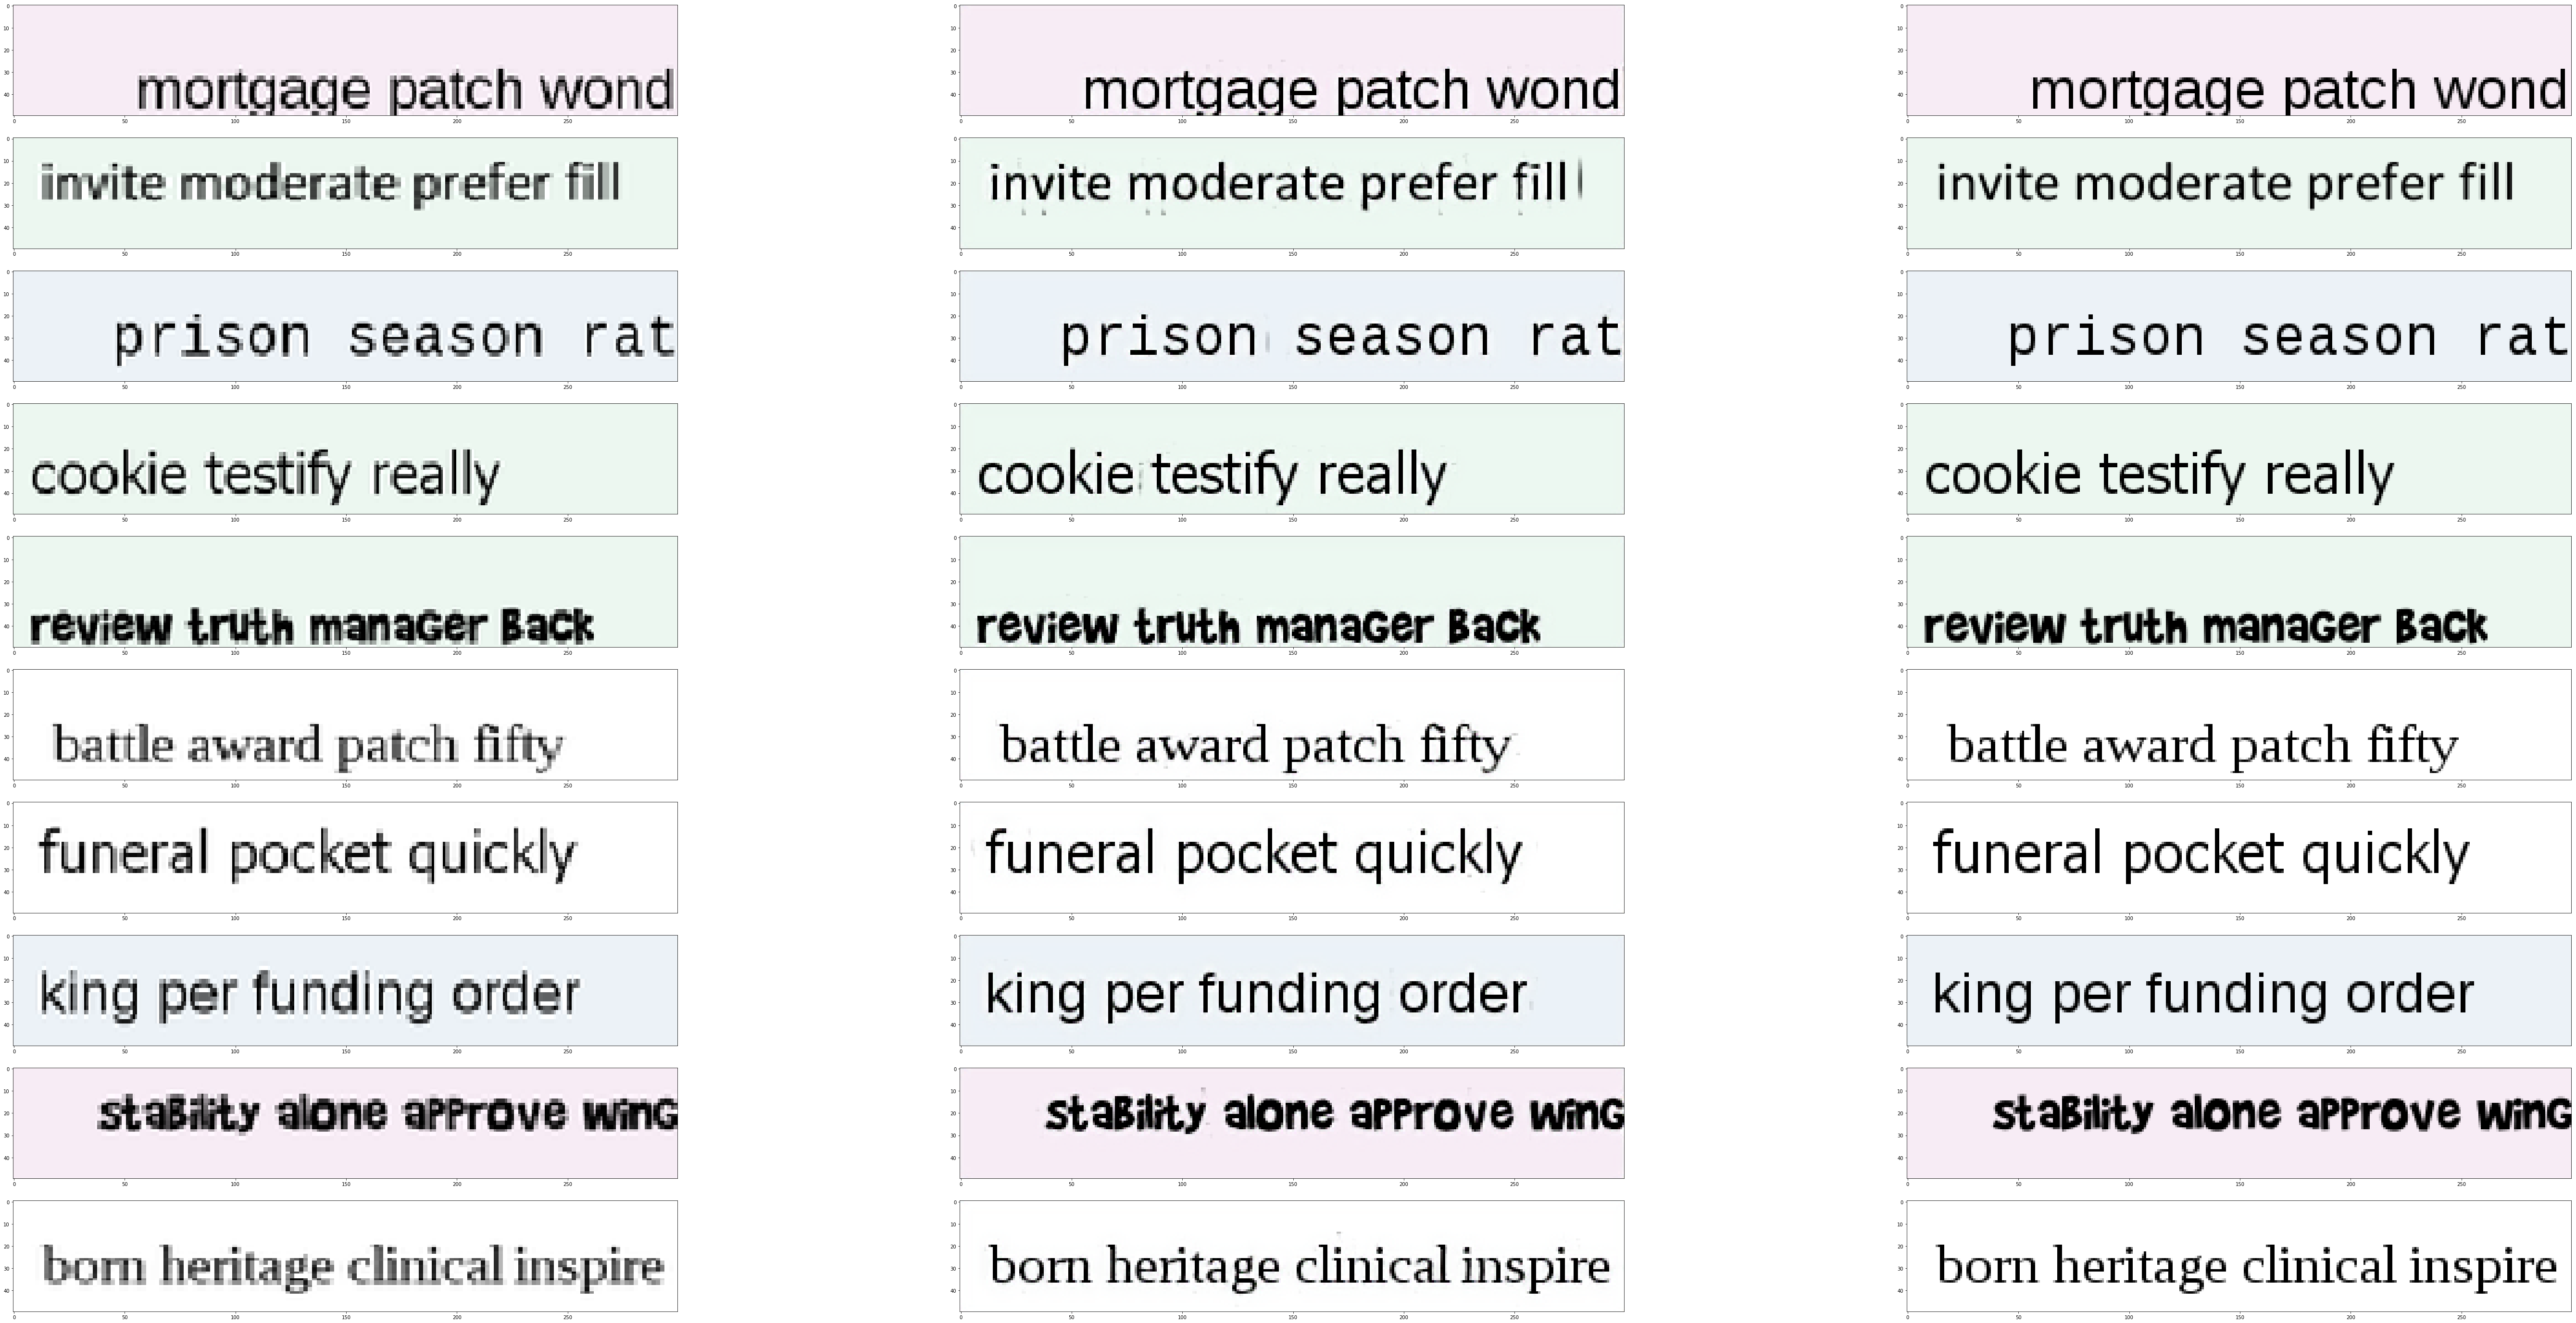

In [15]:
comparing(model, X_dev[42221:42231], y_dev[42221:42231])